In [79]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
from itertools import combinations
import matplotlib
import matplotlib.gridspec as gridspec


In [80]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# import tidynamics as td

## Load and inspect the data

In [81]:
traj = md.load('data/water_nojump_3.xtc',top= 'data/water_top.pdb')
com = md.compute_center_of_mass(traj)
com.shape

(10000001, 3)

In [82]:
traj.timestep

0.1

In [83]:
df = pd.DataFrame(com, columns=['x', 'y', 'z'])
df['t'] = traj.time/1000

df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['x', 'y', 'z'], var_name='coord', )

df_melt.head()

,t,coord,value
0,0.0000,x,2.322035
1,0.0001,x,2.317498
2,0.0002,x,2.348874
3,0.0003,x,2.367788
4,0.0004,x,2.341420


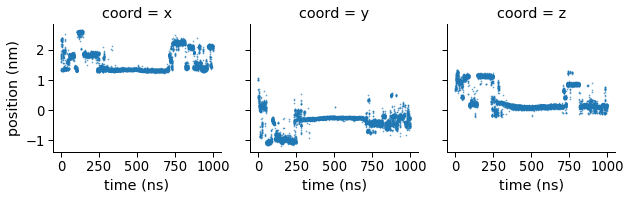

In [84]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(df_melt.iloc[::1000,:], col='coord')
    g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
    g.set_axis_labels('time (ns)', 'position (nm)')
    plt.savefig('thesis chapter/traj_3_xyz.png', bbox_inches='tight')

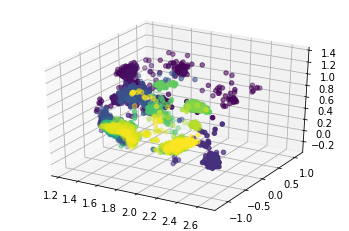

In [85]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])

### Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [86]:
dt_ps = traj.timestep
dt_ns = dt_ps/1000 # in ns
window = 1 # window size in ns
n_frames = int(window/dt_ns) # number of frames in a window
n_splits = com.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(com, n_splits) # the split up 

In [87]:
sample = pd.DataFrame(traj_split[136])
sample.head()

,0,1,2
0,2.578284,-0.985622,0.214775
1,2.611725,-1.000329,0.189633
2,2.612940,-0.944668,0.206004
3,2.637449,-0.994035,0.204889
4,2.605083,-0.988115,0.188019


## Specific timeslice

In [88]:
np.random.seed(42)
axis = ['x', 'y', 'z']
idx = 0


### Coordinates

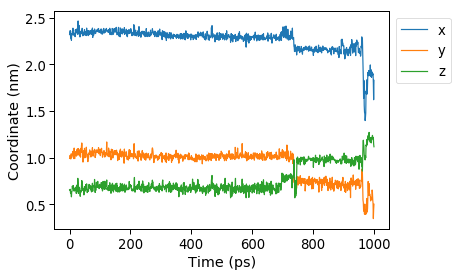

In [89]:
with sns.plotting_context('paper', font_scale=1.5):
    stride = 10
    t = np.arange(traj_split[idx].shape[0])*dt_ps
    fig, ax = plt.subplots()
    for i in range(len(axis)):
        ax.plot(t[::stride], traj_split[idx][::stride, i], label=axis[i])
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_ylabel('Coordinate (nm)')
    ax.set_xlabel('Time (ps)')
    plt.savefig('images/xyz-slice-{}.png'.format(idx), bbox_inches='tight', dpi=450)

### TICA

(0, 500)

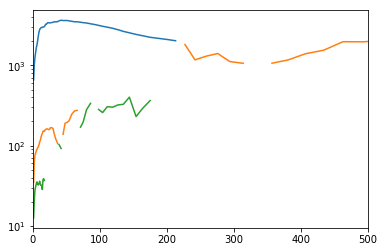

In [90]:
tica_lags = np.unique((np.logspace(np.log10(1), np.log10(600), 100)).astype(int))
ticas = [coor.tica(traj_split[idx], lag=int(lag/dt_ps), dim=3,  kinetic_map=True) for lag in tica_lags]
tica_eigs = np.concatenate([t.eigenvalues[:, np.newaxis] for t in ticas ], axis=1)
tica_ts = np.concatenate([t.timescales[:, np.newaxis] for t in ticas ], axis=1)
tica_ts = -tica_lags/dt_ps/np.log(tica_eigs)

plt.plot(tica_lags, tica_ts.T)
plt.yscale('log')
plt.xlim(0, 500)

### VAMP

In [91]:
vamps = [coor.vamp(traj_split[idx], lag=int(lag/float(dt_ps)), dim=3, scaling='km', right=True) for lag in tica_lags]
vamp_sv = np.concatenate([t.singular_values[:, np.newaxis] for t in vamps ], axis=1)
vamp_ts = -tica_lags/dt_ps/np.log(vamp_sv)


(0, 500)

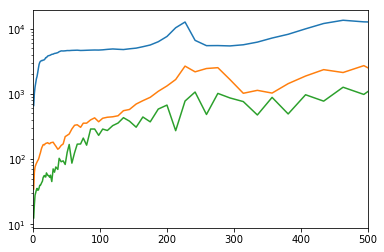

In [92]:
plt.plot(tica_lags, vamp_ts.T)
plt.yscale('log')
plt.xlim(0, 500)

### MSM

In [93]:
dtrajs_obj = coor.cluster_kmeans(traj_split[idx], k = np.sqrt(n_frames).astype(int), max_iter=100)
dtrajs = dtrajs_obj.dtrajs

In [94]:
its = msm.its(dtrajs, lags=(tica_lags/dt_ps).astype(int), nits=5, errors='bayes')

In [95]:
vamp10 = vamps[1]
tica10 = ticas[1]
mm10 = msm.estimate_markov_model(dtrajs, lag=int(10/dt_ps))
mm100 = msm.estimate_markov_model(dtrajs, lag=int(100/dt_ps))
hmm10 = mm10.coarse_grain(2)
hmm100 = mm100.coarse_grain(2)
mms = [hmm10, vamp10]

In [96]:
label_coord = (0.0, 1.05)

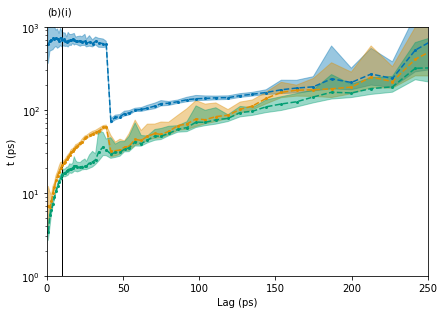

In [97]:
# with sns.plotting_context('paper', font_scale=1.5):
#     fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
def plot_its(axes, its):
    xmax, ymax = 250, 10**3
    nits = 3
    colors = sns.color_palette('colorblind', nits)
    
    srt = np.argsort(its.lags)
    lags = its.lags
    for i in range(nits):
        axes.plot(
                lags[srt] * dt_ps, its.get_sample_mean(process=i)[srt] * dt_ps, marker='o',
                color=colors[i % len(colors)], linestyle='dashed', markersize=2)
        (lconf, rconf) = its.get_sample_conf(0.95, i)
        axes.fill_between(
            lags[srt]*dt_ps, lconf[srt]*dt_ps , rconf[srt]*dt_ps,
            alpha=0.4, color=colors[i % len(colors)])
    
    axes.set_yscale('log')
    axes.set_xlim(0, xmax)
    axes.set_ylim(1, ymax)
    
    axes.vlines(10, 0, ymax, color='k', lw=1)
    axes.set_ylabel('t (ps)')
    axes.set_xlabel('Lag (ps)')
    
    plt.tight_layout(h_pad=0.1, w_pad=0.1, pad=0.1)
    axes.annotate(s='(b)(i)', xy=label_coord, xycoords='axes fraction')
#     plt.savefig('images/msm-its-slice-{}.png'.format(idx), bbox_inches='tight', dpi=450)

fig, ax = plt.subplots()
plot_its(ax, its)

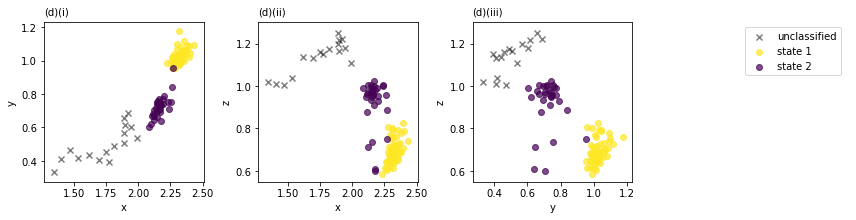

In [98]:

def plot_projections(axes, mm, dtraj_obj):
    combs = list(combinations(range(3), 2))
    ccs = dtraj_obj.clustercenters

    ncols= len(combs)
    labels=['i', 'ii', 'iii']
#     fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6*(ncols-1),4))
    obs = mm.observable_set
    non_obs = np.array([x for x in range(ccs.shape[0]) if not x in obs])
    
    N = mm.nstates
    cmap = matplotlib.cm.get_cmap('viridis_r',N)
    cols = [cmap(n) for n in range(mm.nstates)]
    
    mas = mm.metastable_assignments
    n_states = np.max(mas)+1
#     print(non_obs)
    for j in range(len(combs)): 
        if len(non_obs) > 0:
            axes[j].scatter(x = ccs[non_obs, combs[j][0]], y = ccs[non_obs, combs[j][1]], 
                              c='k',marker='x', alpha=0.5, label='unclassified')
        for i in range(n_states):
            obs_idx = obs[np.where(mas==i)[0]]
            axes[j].scatter(x = ccs[obs_idx, combs[j][0]], y = ccs[obs_idx, combs[j][1]], 
                          alpha=0.7,color=cols[i], label='state {}'.format(i+1))
            
        axes[j].set_ylabel(axis[combs[j][1]])
        axes[j].set_xlabel(axis[combs[j][0]])
        ratio = 1
        axes[j].set_aspect(1.0/axes[j].get_data_ratio()*ratio)
        axes[j].annotate(s='(d)({})'.format(labels[j]), xy=label_coord, xycoords='axes fraction')
    
    ylim = axes[0].get_ylim()
    xlim = axes[0].get_xlim()
    axes[-1].set_ylim(ylim)
    axes[-1].set_xlim(xlim)
    axes[-1].set_aspect(axes[0].get_aspect())
    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper right')
    _ = [v.set_visible(False) for k, v in axes[-1].spines.items()]
    axes[-1].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
#     axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('images/hmm-classification-slice-{}.png'.format(idx), bbox_inches='tight', dpi=450)
fig, axes = plt.subplots(1,4, figsize=(12,4))
plot_projections(axes, hmm10, dtrajs_obj )
plt.tight_layout()

In [99]:
from matplotlib import ticker as tk

In [100]:
def plot_matrix(ax, mm):
    
    N = mm.nstates
    cmap = matplotlib.cm.get_cmap('viridis_r',N)
    cols = [cmap(n) for n in range(N)]
    ax.bar(np.arange(N)+1, mm.pi)
    ax.set_ylabel("Eq'm. dist.", labelpad=0)
    ax.set_xlabel('State')
    ax.set_ylim(0, 1.1)
    ax.annotate(s='(c)(i)', xy=label_coord, xycoords='axes fraction')
    formatter = tk.FuncFormatter(lambda x, pos: '{:.0f}%'.format(x*100))
    ax.yaxis.set_major_formatter(formatter)

In [101]:
def plot_xyz(ax, xyz):
    axis=['x', 'y', 'z']
    labels=['i', 'ii', 'iii']
    stride = 10
    t = np.arange(xyz.shape[0])*dt_ps
    for i in range(len(axis)):
        ax[i].plot(t[::stride], xyz[::stride, i])
      
        ax[i].set_ylabel('{} (nm)'.format(axis[i]))
        ax[i].set_xlabel('Time (ps)')
        ax[i].annotate(s='(a)({})'.format(labels[i]), xy=label_coord, xycoords='axes fraction')


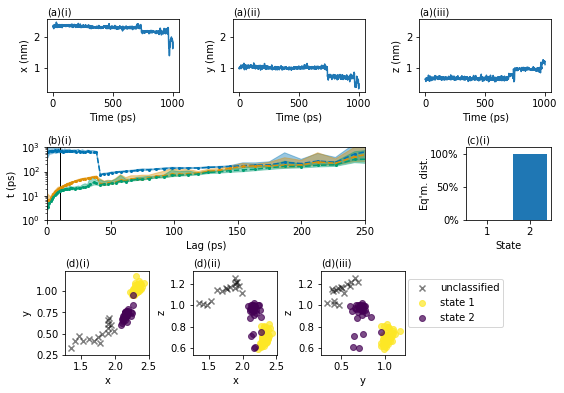

In [102]:
# with sns.plotting_context('paper', font_scale=1):
scale=7/6
fig = plt.figure(figsize=(6*scale, 4*scale))

gs1 = gridspec.GridSpec(2, 11, figure=fig,  left=0, right=1, bottom=0.4, top=1,hspace=0.75)

ax_xyzs = [fig.add_subplot(gs1[0, 4*i:4*i+3]) for i in range(1)]
ax_xyzs = ax_xyzs + [fig.add_subplot(gs1[0, 4*i:4*i+3], sharex=ax_xyzs[0], sharey=ax_xyzs[0]) for i in range(1,3)]

ax_its = fig.add_subplot(gs1[1, :7])
ax_tm = fig.add_subplot(gs1[1, 9:11])

gs2 = gridspec.GridSpec(1, 12, figure=fig, left=0, right=1, bottom=0, top=0.25)
ax_projs = [fig.add_subplot(gs2[0, 3*i:3*i+3]) for i in range(1)]
ax_projs = ax_projs + [fig.add_subplot(gs2[0, 3*i:3*i+3]) for i in range(1,3)]
ax_projs = ax_projs + [fig.add_subplot(gs2[0, 9:11])]

plot_xyz(ax_xyzs, traj_split[idx])
plot_its(ax_its, its)
plot_projections(ax_projs, hmm10, dtrajs_obj)
plot_matrix(ax_tm, hmm10)
# gs1.tight_layout(fig)
# gs2.tight_layout(fig, w_pad=2)
plt.savefig('images/classification-idx-{}.png'.format(idx), bbox_inches='tight', dpi=450)

In [103]:
import paper.my_network_plot as myplt

In [104]:
hmm10.transition_matrix

array([[ 0.98654076,  0.01345924],
       [ 0.        ,  1.        ]])

In [105]:
hmm10.pi


array([ 0.,  1.])

In [106]:
def plot_network(mm, ax, pad=0.4):
    N = mm.nstates
    # Colors 
    cmap = matplotlib.cm.get_cmap('viridis_r',N)
    cols = [cmap(n) for n in range(N)]
    
    # Network
    r = 0.8
    shift = 1 #0*np.pi/6
    x = np.array([r * np.cos(2*np.pi*n/N + shift) for n in range(N)])
    y = np.array([r * np.sin(2*np.pi*n/N + shift) for n in range(N)])
#     delta = -0.2
    pos = np.concatenate((x[:, np.newaxis], y[:,np.newaxis]), axis=1)
    _, _ = myplt.plot_markov_model(mm.transition_matrix, ax=ax, 
                                  arrow_curvature=3.5, state_colors=cols,
                                  arrow_label_format = '%2.2f',pos=pos,
                                  figpadding=pad, arrow_scale=0.5, state_scale=2)
    ax.annotate(s='(ii)', xy=(0.3, 1.05), xycoords='axes fraction', family='Times New Roman')

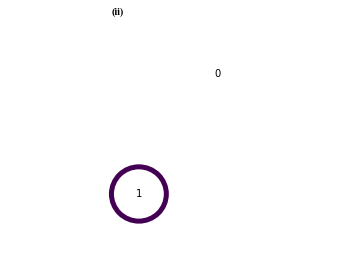

In [107]:
fig, ax = plt.subplots(1)
plot_network(mm=hmm10, ax=ax)